# SPM impact of Alaska's Permanent Fund Dividend

Difference in differences using 1982, the first year of the PFD where it was \$1,000 per person.

## Setup

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import microdf as mdf
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mdf.set_plot_style()

## Load data

In [3]:
dat = pd.read_csv('data/spm_state.csv.gz')
pfd = pd.read_csv('data/pfd_amounts.csv', usecols=['year', 'pfd'])

## Preprocess

Add DD columns. Alaska is state FIPS code 2,
but [prior to 1976](https://cps.ipums.org/cps-action/variables/STATEFIP#comparability_section),
some states [shared](https://cps.ipums.org/cps-action/variables/STATEFIP#codes_section) FIPS codes.
These are all codes that have represented Alaska:
* 68: Alaska-Hawaii
* 80: Alaska-Washington-Hawaii
* 88: Washington-Oregon-Alaska-Hawaii

In [4]:
AK_FIPS = [2, 68, 80, 88]

Show which code represented Alaska in each year.

In [5]:
dat[dat.statefip.isin(AK_FIPS) &
    (dat.year < 1976)].groupby('year').statefip.min()

year
1967    80
1968    80
1969    80
1970    80
1971    80
1972    88
1973    88
1974    88
1975    88
Name: statefip, dtype: int64

Drop data before 1976 to avoid combining with other states.
The first PFD check was in 1982, so this still gives 6 years of pre-period.

In [6]:
YEAR_START = 1976

In [7]:
dat = dat[dat.year >= YEAR_START]

Merge to PFD.

In [8]:
dat = dat.merge(pfd, on='year', how='left').fillna(0)

Add DD variables.

In [9]:
dat['alaska'] = dat.statefip == 2
dat['post'] = dat.year >= 1982
dat['alaska_post'] = dat.alaska & dat.post

Add intensity DD variables, including a trend and Alaska-specific trend.
Also create pfd in \$1,000 increments for more understandable coefficients.

In [10]:
dat['pfd_k'] = dat.pfd / 1000
dat['alaska_pfd_k'] = dat.alaska * dat.pfd_k
dat['alaska_year'] = dat.alaska * dat.year

Set bools to ints for regressions, and add a constant.

In [11]:
dat.replace(False, 0, inplace=True)

In [12]:
dat = sm.add_constant(dat)

Add polynomials and interactions as controls.

In [13]:
dat['age2'] = dat.age * dat.age
dat['female_age'] = dat.female * dat.age
dat['female_age2'] = dat.female * dat.age2

Simplest model just compares two years.

In [14]:
dat8182 = dat[dat.year.isin([1981, 1982])]

## Graphs

In [15]:
dat['poorw'] = dat.poor * dat.w

In [16]:
povtrend = dat.groupby('year')[['poorw', 'w']].sum()
povtrend['pov_rate'] = povtrend.poorw / povtrend.w

In [17]:
povtrend_ak = dat.groupby(['year', 'alaska'])[['poorw', 'w']].sum()
povtrend_ak['pov_rate'] = povtrend_ak.poorw / povtrend_ak.w
# Pivot, rename columns, and reorder.
povtrend_ak = povtrend_ak.pivot_table('pov_rate', 'year', 'alaska')
povtrend_ak.columns = ['rest', 'ak']
povtrend_ak = povtrend_ak[['ak', 'rest']]

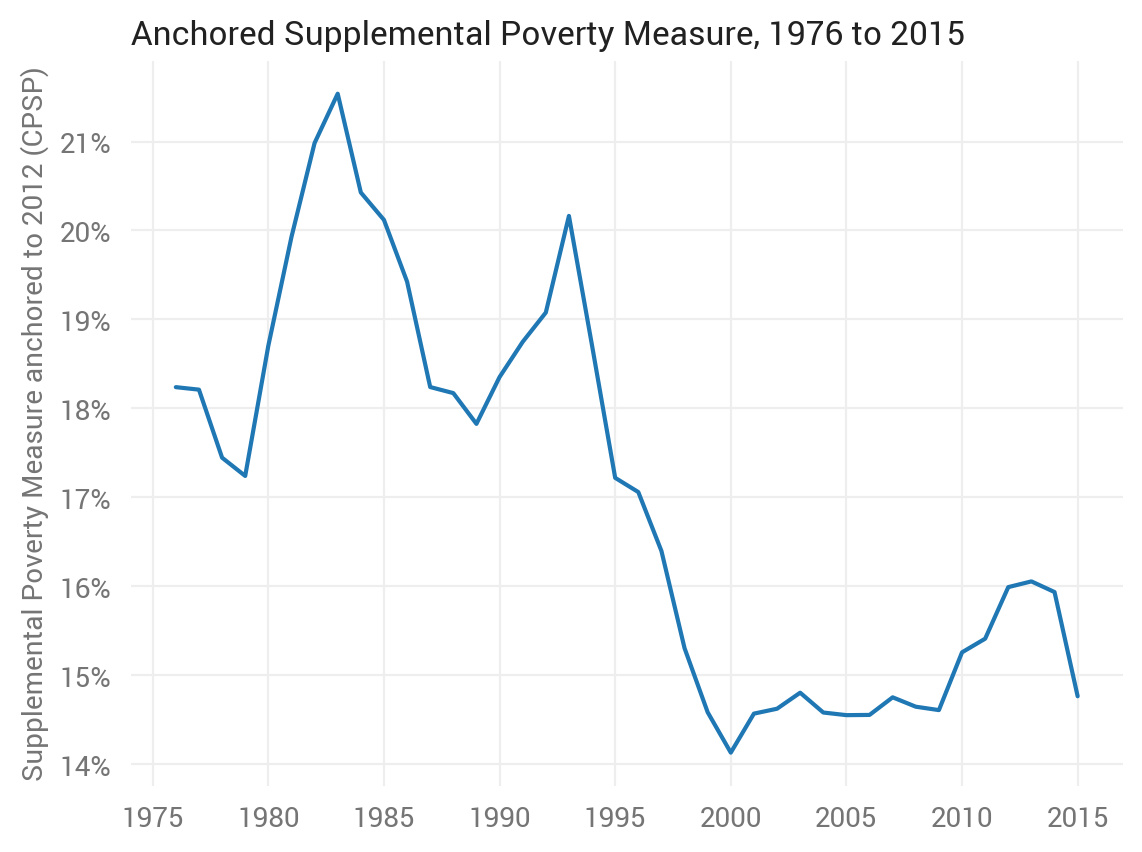

In [18]:
ax = povtrend.pov_rate.plot()
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
plt.xlabel('')
plt.ylabel('Supplemental Poverty Measure anchored to 2012 (CPSP)')
plt.title('Anchored Supplemental Poverty Measure, ' + str(YEAR_START) + 
          ' to 2015', loc='left')
plt.show()

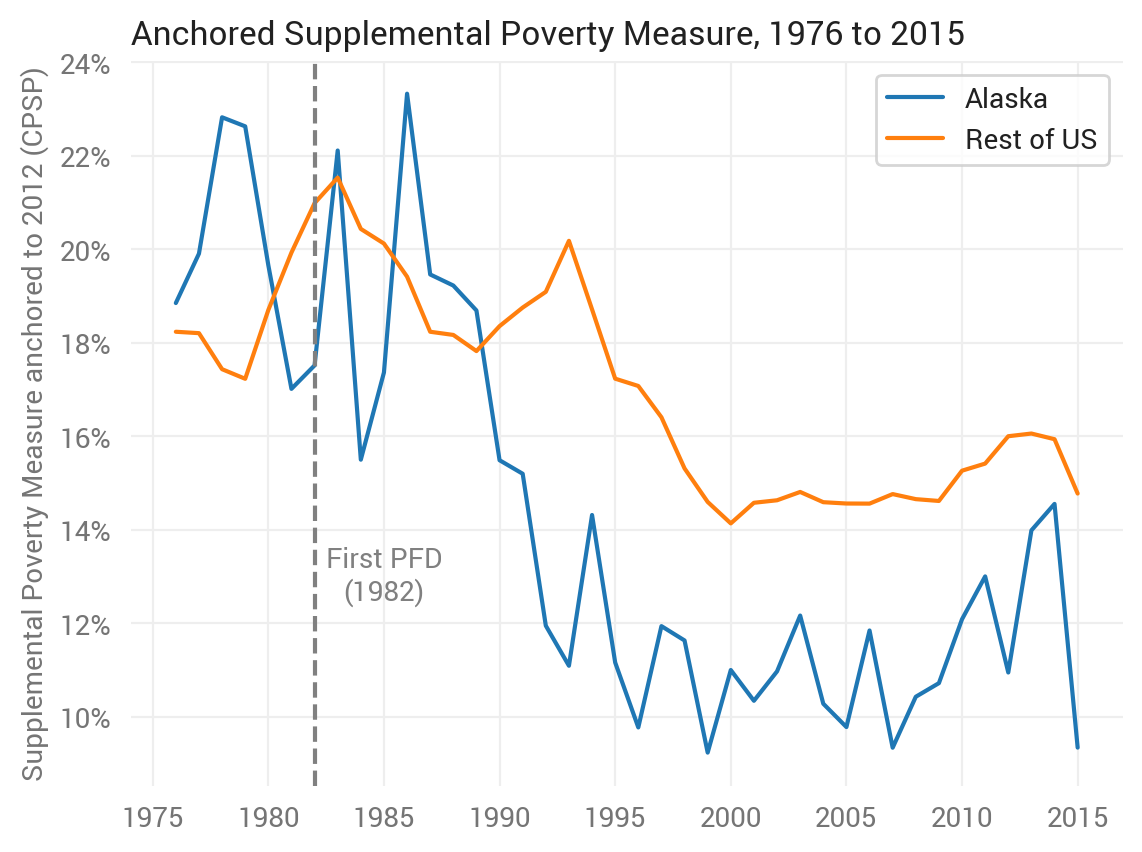

In [19]:
ax = povtrend_ak.plot()
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1, decimals=0))
plt.legend(['Alaska', 'Rest of US'])
plt.xlabel('')
ax.axvline(1982, c='gray', linestyle='--')
plt.text(1985, 0.125, 'First PFD\n(1982)',
         horizontalalignment='center', zorder=10, c='gray')
plt.ylabel('Supplemental Poverty Measure anchored to 2012 (CPSP)')
plt.title('Anchored Supplemental Poverty Measure, ' + str(YEAR_START) + 
          ' to 2015', loc='left')
plt.show()

### Compare to PFD amount

In [20]:
povtrend_ak['ak_minus_rest'] = povtrend_ak.ak - povtrend_ak.rest
povtrend_ak = povtrend_ak.join(pfd.set_index('year')).fillna(0)

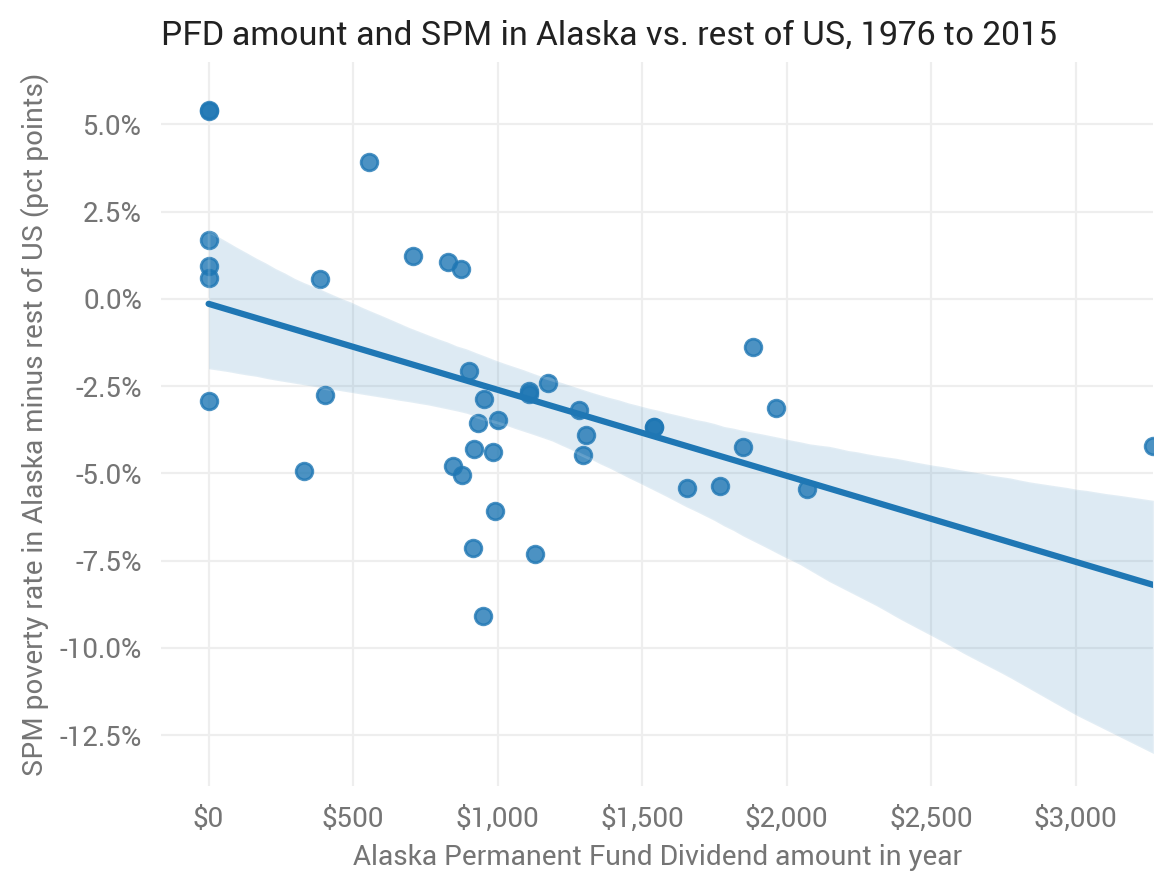

In [21]:
ax = sns.regplot(x='pfd', y='ak_minus_rest', data=povtrend_ak)
plt.title('PFD amount and SPM in Alaska vs. rest of US, 1976 to 2015',
          loc='left')
plt.xlabel('Alaska Permanent Fund Dividend amount in year')
ax.xaxis.set_major_formatter(mdf.dollar_format())
plt.ylabel('SPM poverty rate in Alaska minus rest of US (pct points)')
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))

R squared

In [22]:
povtrend_ak[['pfd', 'ak_minus_rest']].corr().iloc[0, 1] ** 2

0.26250885416204317

## Regression

### Regression function

In [23]:
def reg(df, y, x, cluster=None):
    """ Run WLS regression. Also drops all incomplete rows across x and y.
    
    Args:
        df: DataFrame.
        y: Name of y column.
        x: List of x column names (const is added).
        cluster: Column name to cluster on. Defaults to None, in which case
            standard HC1 robust standard errors are reported instead.
    """
    cols = x + [y, 'w', 'const']
    tmp = df[cols].dropna()
    m = sm.WLS(tmp[y], tmp[x + ['const']], weights=tmp['w'], missing='drop')
    if cluster:
        return m.fit(cov_type='cluster',
                     cov_kwds={'groups': tmp[cluster].values})
    return m.fit(cov_type='HC1')

### Simple DD

In [24]:
DD_VARS = ['alaska_post', 'alaska', 'post']
CONTROLS = ['female', 'age', 'age2', 'female_age', 'female_age2']

In [25]:
m1 = reg(dat8182, 'poor', DD_VARS)
m1.summary()

/home/mghenis/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:762: RuntimeWarning: divide by zero encountered in log
  llf += 0.5 * np.sum(np.log(self.weights))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                   poor   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     24.54
Date:                Fri, 12 Jun 2020   Prob (F-statistic):           7.22e-16
Time:                        21:44:55   Log-Likelihood:                   -inf
No. Observations:              324822   AIC:                               inf
Df Residuals:                  324818   BIC:                               inf
Df Model:                           3                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
alaska_post    -0.0056      0.012     -0.465      0.642      -0.029       0.018
alaska         -0.0292      0.009     -3.357      0.001      -0.046      -0.012
post            0.0106      0.002      6.724      0.000       0.007       0.014
const           0.1993      0.001    180.560      0.000       0.197       0.201
==============================================================================
Omnibus:                    75086.573   Durbin-Watson:                   1.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           138951.112
Skew:                           1.553   Prob(JB):                         0.00
Kurtosis:                       3.790   Cond. No.                         62.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

With controls.

In [26]:
m_controls = reg(dat8182, 'poor', DD_VARS + CONTROLS)
m_controls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                   poor   R-squared:                       0.023
Model:                            WLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     743.1
Date:                Fri, 12 Jun 2020   Prob (F-statistic):               0.00
Time:                        21:44:55   Log-Likelihood:                   -inf
No. Observations:              324822   AIC:                               inf
Df Residuals:                  324813   BIC:                               inf
Df Model:                           8                                         
Covariance Type:                  HC1                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
alaska_post    -0.0034      0.012     -0.286      0.775      -0.027       0.020
alaska         -0.0333      0.009     -3.818      0.000      -0.050      -0.016
post            0.0107      0.002      6.900      0.000       0.008       0.014
female          0.0048      0.005      1.023      0.306      -0.004       0.014
age            -0.0093      0.000    -48.445      0.000      -0.010      -0.009
age2          9.34e-05   2.42e-06     38.589      0.000    8.87e-05    9.81e-05
female_age      0.0013      0.000      4.815      0.000       0.001       0.002
female_age2 -6.354e-06   3.35e-06     -1.897      0.058   -1.29e-05    2.12e-07
const           0.3402      0.003    101.294      0.000       0.334       0.347
==============================================================================
Omnibus:                    72744.266   Durbin-Watson:                   1.053
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           132142.775
Skew:                           1.507   Prob(JB):                         0.00
Kurtosis:                       3.826   Cond. No.                     1.52e+05
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.52e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Intensity DD

Use PFD amount.

In [27]:
DD_INT_VARS = ['alaska_pfd_k', 'alaska', 'pfd_k']
DD_INT_CONTROLS = ['year', 'alaska_year']

In [28]:
m_intensity = reg(dat, 'poor', DD_INT_VARS + CONTROLS + DD_INT_CONTROLS)
m_intensity.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                   poor   R-squared:                       0.016
Model:                            WLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     7603.
Date:                Fri, 12 Jun 2020   Prob (F-statistic):               0.00
Time:                        21:45:16   Log-Likelihood:                   -inf
No. Observations:             6924826   AIC:                               inf
Df Residuals:                 6924815   BIC:                               inf
Df Model:                          10                                         
Covariance Type:                  HC1                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
alaska_pfd_k    -0.0122      0.003     -4.844      0.000      -0.017      -0.007
alaska           1.4008      0.319      4.398      0.000       0.776       2.025
pfd_k           -0.0058      0.000    -17.035      0.000      -0.007      -0.005
female           0.0104      0.001     10.694      0.000       0.008       0.012
age             -0.0061   3.93e-05   -154.833      0.000      -0.006      -0.006
age2          5.954e-05   4.95e-07    120.247      0.000    5.86e-05    6.05e-05
female_age       0.0001   5.53e-05      1.820      0.069   -7.71e-06       0.000
female_age2    7.04e-06    6.9e-07     10.200      0.000    5.69e-06    8.39e-06
year            -0.0010   2.08e-05    -50.296      0.000      -0.001      -0.001
alaska_year     -0.0007      0.000     -4.426      0.000      -0.001      -0.000
const            2.3615      0.041     57.210      0.000       2.281       2.442
==============================================================================
Omnibus:                  2444733.327   Durbin-Watson:                   1.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6566810.115
Skew:                           1.972   Prob(JB):                         0.00
Kurtosis:                       5.683   Cond. No.                     1.74e+07
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 1.74e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Appendix

### Regressions with clustered standard errors

Each of these produces incorrect standard errors due to rank deficiency.

In [29]:
m_clust = reg(dat8182, 'poor', DD_VARS, 'alaska')
m_clust.summary()

/home/mghenis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 3, but rank is 2
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                   poor   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                 1.874e+26
Date:                Fri, 12 Jun 2020   Prob (F-statistic):           5.17e-14
Time:                        21:45:17   Log-Likelihood:                   -inf
No. Observations:              324822   AIC:                               inf
Df Residuals:                  324818   BIC:                               inf
Df Model:                           3                                         
Covariance Type:              cluster                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
alaska_post    -0.0056   1.66e-15  -3.35e+12      0.000      -0.006      -0.006
alaska         -0.0292   2.18e-15  -1.34e+13      0.000      -0.029      -0.029
post            0.0106   1.63e-16   6.49e+13      0.000       0.011       0.011
const           0.1993   1.79e-15   1.12e+14      0.000       0.199       0.199
==============================================================================
Omnibus:                    75086.573   Durbin-Watson:                   1.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           138951.112
Skew:                           1.553   Prob(JB):                         0.00
Kurtosis:                       3.790   Cond. No.                         62.0
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [30]:
m_intensity_clust = reg(dat, 'poor', DD_INT_VARS + CONTROLS + DD_INT_CONTROLS,
                        'alaska')
m_intensity_clust.summary()

/home/mghenis/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1832: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 10, but rank is 1
  'rank is %d' % (J, J_), ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                   poor   R-squared:                       0.016
Model:                            WLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                 2.323e+07
Date:                Fri, 12 Jun 2020   Prob (F-statistic):           0.000132
Time:                        21:45:40   Log-Likelihood:                   -inf
No. Observations:             6924826   AIC:                               inf
Df Residuals:                 6924815   BIC:                               inf
Df Model:                          10                                         
Covariance Type:              cluster                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
alaska_pfd_k    -0.0122   6.66e-07  -1.83e+04      0.000      -0.012      -0.012
alaska           1.4008      0.000   5175.802      0.000       1.400       1.401
pfd_k           -0.0058   4.97e-08  -1.18e+05      0.000      -0.006      -0.006
female           0.0104   7.33e-05    141.866      0.000       0.010       0.011
age             -0.0061   1.19e-05   -511.603      0.000      -0.006      -0.006
age2          5.954e-05   1.13e-07    528.693      0.000    5.93e-05    5.98e-05
female_age       0.0001   6.02e-06     16.703      0.000    8.88e-05       0.000
female_age2    7.04e-06   5.39e-08    130.674      0.000    6.93e-06    7.15e-06
year            -0.0010   2.94e-07  -3563.064      0.000      -0.001      -0.001
alaska_year     -0.0007   1.33e-07  -5331.994      0.000      -0.001      -0.001
const            2.3615      0.000   6117.037      0.000       2.361       2.362
==============================================================================
Omnibus:                  2444733.327   Durbin-Watson:                   1.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6566810.115
Skew:                           1.972   Prob(JB):                         0.00
Kurtosis:                       5.683   Cond. No.                     1.74e+07
==============================================================================

Warnings:
[1] Standard Errors are robust to cluster correlation (cluster)
[2] The condition number is large, 1.74e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""